## Wavefile Read/Write

Open and read a wavefile

In [6]:
import wave
import numpy as np
import matplotlib.pyplot as plt

signal_input_file_path = './electric_guitar_sample.wav'
signal_output_file_path = './outputs/unaltered_output.wav'

class Audio_Signal:
    def __init__(self, input_file_path, output_file_path):
        self.input_file_path = input_file_path
        self.output_file_path = output_file_path

    def load_audio(self):
        audio_signal = wave.open(self.input_file_path, 'r')
        
        self.frame_count = audio_signal.getnframes()
        self.channel_count = audio_signal.getnchannels()
        self.sample_width = audio_signal.getsampwidth()
        self.sample_rate = audio_signal.getframerate()
        self.frame_rate = audio_signal.getframerate() * 2

        self.audio_frames = audio_signal.readframes(self.frame_count)
        self.audio_frames = np.frombuffer(self.audio_frames, dtype = np.int16)
    
    def write_to_wav_file(self):
        output_file = wave.open(self.output_file_path, 'w')
        
        output_file.setnchannels(self.channel_count)
        output_file.setsampwidth(self.sample_width)
        output_file.setframerate(self.sample_rate)
        output_file.writeframes(self.audio_frames)
        
        output_file.close()
    
    def plot_audio_data(self):
        audio_length = len(self.audio_frames)

        self.time_signal = np.linspace(0, audio_length / self.frame_rate, num = audio_length)

        plt.figure()
        plt.plot(self.time_signal, self.audio_frames)
        plt.xlabel("Time (s)")
        plt.ylabel("Signal Amplitude")

        plt.show()
    
    def get_sample_rate(self):
        pass

print("Done")

Done


In [55]:
from scipy.signal import kaiserord, firwin, freqz
from pylab import figure, plot, title, grid, xlabel, ylabel

class Filter:
    def __init__(self, filter_type, nyquist_rate=22050, stop_band_attentuation_dB=60, low_transition_freq=400, high_transition_freq=4000):
        #! Adjust stop_band_attentuation_dB to control signal equalization
        self.filter_type = filter_type
        self.nyquist_rate = nyquist_rate
        self.transition_width = 5000 / nyquist_rate #! Assign 5000 value to variable
        self.stop_band_attenuation_dB = stop_band_attentuation_dB
        self.low_transition_freq = low_transition_freq
        self.high_transition_freq = high_transition_freq
        
        self.filter_coefs = []

        self.calculate_filter_order()
        self.generate_filter_coefs()
    
    def calculate_filter_order(self):
        self.FIR_order, self.beta = kaiserord(self.stop_band_attenuation_dB, self.transition_width)
    
    def generate_filter_coefs(self):
        if self.filter_type == "low":
            self.generate_lowfreq_filter()
        elif self.filter_type == "mid":
            self.generate_midfreq_filter()
        elif self.filter_type == "high":
            self.generate_highfreq_filter()
    
    def generate_lowfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, self.high_transition_freq, pass_zero='highpass', fs=self.nyquist_rate*2)

    def generate_midfreq_filter(self):
        self.FIR_order = (self.FIR_order * 3)
        self.filter_coefs = firwin(self.FIR_order, [self.low_transition_freq / self.nyquist_rate, self.high_transition_freq / self.nyquist_rate], pass_zero='bandstop')#, fs=self.nyquist_rate*2)

    def generate_highfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, self.low_transition_freq, pass_zero='lowpass', fs=self.nyquist_rate*2)

    def write_coefs_to_file(self):
        #! Not sure if this is how to change the filter coefficients in block memory
        pass

    def plot_filter(self):
        figure()
        w, h = freqz(self.filter_coefs, worN=8000)
        plot((w/np.pi)*self.nyquist_rate, np.absolute(h), linewidth=2)
        title('Filter Curves')
        xlabel("Frequency")
        ylabel("Filter Gain")
        grid(True)

print("Done")

Done


In [13]:
input_signal = Audio_Signal(signal_input_file_path, signal_output_file_path)

input_signal.load_audio()

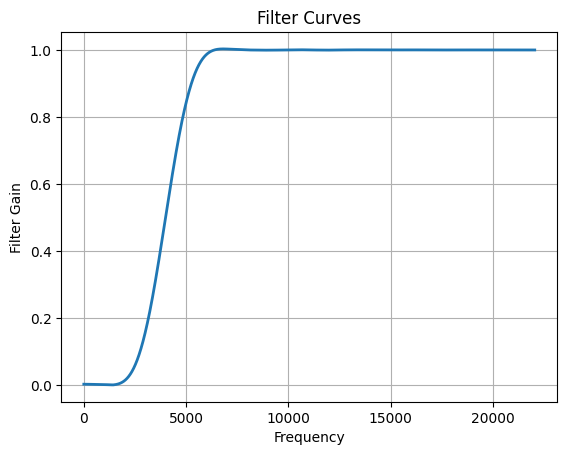

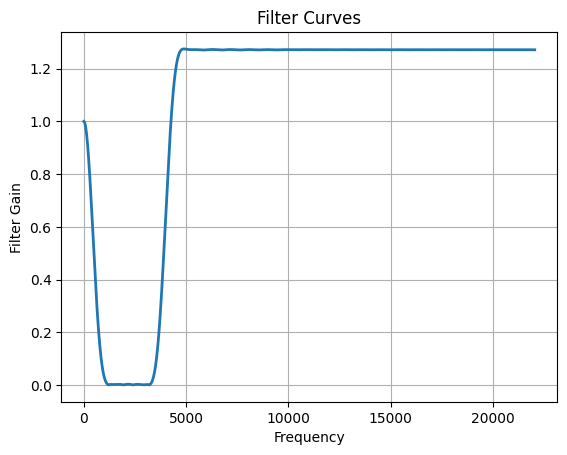

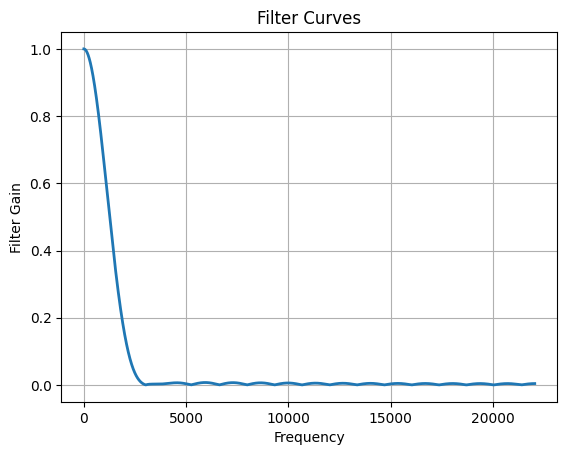

In [56]:
lowfreq_filter = Filter('low')
midfreq_filter = Filter('mid')
highfreq_filter = Filter('high')

lowfreq_filter.plot_filter()
midfreq_filter.plot_filter()
highfreq_filter.plot_filter()

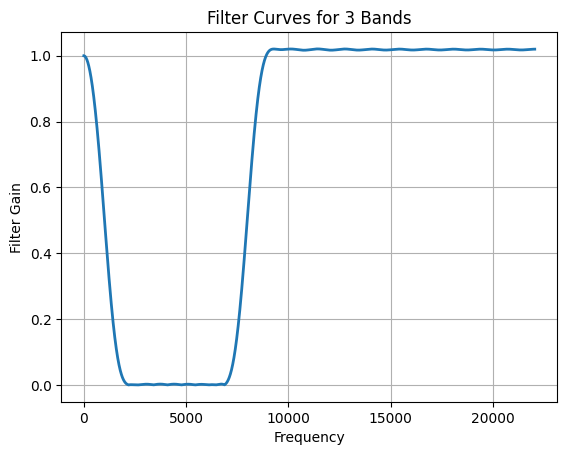

In [28]:
import numpy as np
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt
from pylab import figure, plot, title, grid, xlabel, ylabel

# Define the parameters for the bandstop filter
num_taps = 101  # Number of filter taps
cutoff_freq = [2, 8]  # Bandstop filter cutoff frequencies in Hz
sampling_freq = 100  # Sampling frequency in Hz

# Generate the coefficients for the bandstop filter
coefficients = firwin(num_taps, cutoff_freq, pass_zero=True, fs=sampling_freq)
coefficients = firwin(67, [1000 / 22050, 8000 / 22050], pass_zero='bandstop')

# Plot the frequency response of the filter
# w, h = freqz(coefficients, worN=8000)
# frequencies = (sampling_freq * 0.5 / np.pi) * w
# amplitude_response = 20 * np.log10(abs(h))

# fig, ax1 = plt.subplots()
# ax1.plot(frequencies, amplitude_response, 'b')
# ax1.set_ylabel('Amplitude [dB]', color='b')
# ax1.set_xlabel('Frequency [Hz]')
# ax1.grid()

# plt.title('Frequency response of the bandstop filter')
# plt.show()

figure()
w, h = freqz(coefficients, worN=8000)
plot((w/np.pi)*nyquist_rate, np.absolute(h), linewidth=2)
title('Filter Curves for 3 Bands')
xlabel("Frequency")
ylabel("Filter Gain")
grid(True)